# **PROJECT-5. Анализ поведения пользователей и оценка эффективности каналов их привлечения.**

**Цель проекта:** используя данные фронтовой аналитики из AppMetrica проанализировать поведение пользователей сервиса по доставке продуктов на дом, а также оценить эффективность каналов их привлечения в 1 кв. 2020г.

**Задачи проекта:**



1.   Оценить эффективность каналов привлечения.
2.   Проанализировать воронку продаж.
3.   Провести когортный анализ пользователей приложения.

**Выполнил:** студент группы DAPR-80 Верба Александр.

*Для анализа каналов привлечения пользователей и их поведения в приложении будем использовать данные, выгруженные из AppMetrica за период с 1 января по 31 марта 2020г. (по пользователям, зарегистрированным позднее 1 января 2020г.). Файл выгрузки называется "SF_case_data.csv".*

**1. Оценка эффективности каналов привлечения.**


Для начала импортируем библиотеку Pandas, необходимую для создания DataFrame из имеющихся данных. Прочитаем данные из файла в переменную *df.*

Ознакомимся с полученной таблицей на примере первых пяти записей и, прежде чем перейти непосредственно к решению задач, проведём исследование данных.

In [1]:
import pandas as pd

df = pd.read_csv('SF_case_data.csv', low_memory = False)
display(df.head())
print()
display(df.info(show_counts=True))

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   date          2747968 non-null  object 
 1   event         2747968 non-null  object 
 2   purchase_sum  141383 non-null   float64
 3   os_name       2747968 non-null  object 
 4   device_id     2747968 non-null  int64  
 5   gender        2747968 non-null  object 
 6   city          2747968 non-null  object 
 7   utm_source    2747968 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


None

Получив информацию о таблице отметим, что ячейки не имеют пропущенных значений (кроме ячеек с суммой заказа, данные в которых заполнены только для события "покупка"). Однако не все значения имеют подходящие нам типы данных - дата события относится к типу object, приведём её к типу дата, а так же заменим в столбце с источниками привлечения значение "-" (не определен) на более подходящее "not_defined".

In [2]:
df['date'] = pd.to_datetime(df['date'])
df = df.replace({'utm_source': {'-':'not_defined'}})

Сформируем сводную таблицу *events_df,* содержащую информацию об общем количестве событий в приложении по дням. Для визуализации полученных результатов используем график из модуля plotly.graph_objects библиотеки plotly. По оси абсцисс расположим даты, по оси ординат - количество событий. Импортируем необходимую библиотеку.

In [3]:
events_df = df.groupby('date').agg(events_count=('event', 'count')).reset_index()
display(events_df.head())
print()
print('Ответ на вопрос Задания 1.1.1: Больше всего событий было {}.'.format(events_df.iloc[events_df['events_count'].argmax(), 0].strftime('%d-%m-%Y')))

,date,events_count
0,2020-01-01,19781
1,2020-01-02,21640
2,2020-01-03,20861
3,2020-01-04,19152
4,2020-01-05,21716



Ответ на вопрос Задания 1.1.1: Больше всего событий было 10-01-2020.


In [4]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=events_df['date'], y=events_df['events_count']))
fig.update_layout(height=600, width=1200,
                  legend_orientation="v",
                  legend=dict(x=1, xanchor="center"),
                  title_text='Динамика событий по дням в 1 кв. 2020г.',
                  yaxis=dict(title='Количество событий, шт.'),
                  xaxis=dict(title='Дата'))
fig.show()

***Отметим, что график имеет выраженные взлёты активности пользователей:*** после окончания затяжных новогодних каникул, в конце рабочих недель и в преддверии праздников. Можно предположить, что пользователи искали возможность приобрести продукты на выходные, так как в зимнюю плохую погоду и в связи с набирающей обороты эпидемией предпочитали оставаться дома. Эти резкие скачки активности могли произойти как за счёт действующих клиентов, так и в результате привлечения новых заинтересованных пользователей. Чтобы детальнее разобраться в ситуации посмотрим на динамику установок и привлечения пользователей.

Для определения динамики установок приложения создадим сводную таблицу *installs_daily_df,* в которой подсчитаем количество установок по дням в разрезе источников привлечения. Для визуализации полученных результатов используем график. По оси абсцисс расположим даты, по оси ординат - количество установок приложения в разрезе каналов привлечения.

In [5]:
installs_daily_df = pd.pivot_table(df[df['event'] == 'app_install'], values=['event'], index=['date'], columns=['utm_source'], aggfunc=len).reset_index()
installs_daily_df = installs_daily_df.droplevel(1, axis=1)
installs_daily_df.columns = ['date', 'facebook_ads', 'google_ads', 'instagram_ads',	'not_defined', 'referal', 'vk_ads', 'yandex-direct']
display(installs_daily_df.head())
print()

,date,facebook_ads,google_ads,instagram_ads,not_defined,referal,vk_ads,yandex-direct
0,2020-01-01,337,617,422,761,218,555,669
1,2020-01-02,277,525,408,674,207,463,590
2,2020-01-03,200,427,303,514,140,360,458
3,2020-01-04,161,330,245,387,90,275,343
4,2020-01-05,160,304,197,335,108,249,318


In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['not_defined'], name='not defined'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['yandex-direct'], name='yandex-direct'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['google_ads'], name='google_ads'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['vk_ads'], name='vk_ads'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['instagram_ads'], name='instagram_ads'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['facebook_ads'], name='facebook_ads'))
fig.add_trace(go.Scatter(x=installs_daily_df['date'], y=installs_daily_df['referal'], name='referal'))
fig.update_layout(height=600, width=1200,
                  legend_orientation="v",
                  legend=dict(x=1, xanchor="center"),
                  title_text='Динамика установок приложения в 1 кв. 2020г. по каналам привлечения',
                  yaxis=dict(title='Количество установок, раз'),
                  xaxis=dict(title='Дата'))
fig.show()

Из графика видно, что все каналы показывают схожую между собой динамику установок как в дни наибольшей активности, так и в другие периоды, а пиковые дни инсталлов совпадают с пиками активности пользователей в приложении.

Посмотрим на итоговую результативность каналов привлечения по количеству установок приложения в рассматриваемом периоде. Для этого создадим сводную таблицу *installs_df,* в которой подсчитаем количество установок в разрезе источников привлечения. Отсортируем её по убыванию количества установок и добавим столбец с долей каждого источника привлечения. Для визуализации полученных результатов используем столбчатую диаграмму из модуля plotly.graph_objects библиотеки plotly. По оси абсцисс расположим каналы привлечения, по оси ординат - количество установок приложения.

In [7]:
installs_df = pd.pivot_table(df[df['event'] == 'app_install'], values=['device_id'], index=['utm_source'], aggfunc='nunique').reset_index()
installs_df.rename({'device_id': 'installs_count'}, axis=1, inplace=True)
installs_df = installs_df.sort_values('installs_count', ignore_index=True, ascending=False)
installs_df['installs_ratio'] = round(installs_df['installs_count'] * 100 / installs_df['installs_count'].sum(), 1)
display(installs_df)
print()
print('Ответ на первый вопрос Задания 1.1.4: С канала "{}" было больше всего инсталлов.'.format(installs_df['utm_source'][1]))

,utm_source,installs_count,installs_ratio
0,not_defined,32460,21.0
1,yandex-direct,29368,19.0
2,google_ads,26286,17.0
3,vk_ads,23189,15.0
4,instagram_ads,20096,13.0
5,facebook_ads,13916,9.0
6,referal,9282,6.0



Ответ на первый вопрос Задания 1.1.4: С канала "yandex-direct" было больше всего инсталлов.


In [8]:
fig = go.Figure(data=[go.Bar(
    x=installs_df['utm_source'], y=installs_df['installs_count'],
    text = installs_df['installs_count'],
    texttemplate = '%{value:,.0f}',
    marker_color='#1f77b4'
)])
fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig.update_layout(height=600, width=1200, xaxis_tickangle=-45,
                  title_text='Количество установок приложения в 1 кв. 2020г. по каналам привлечения', 
                  yaxis=dict(title='Количество установок приложения, раз'), 
                  xaxis=dict(title='Канал привлечения', dtick = 1), 
                  showlegend=False)
fig.show()

***Из всех платных каналов привлечения по количеству установок приложения лидируют Яндекс, Гугл и ВК (их доли в общем объёме установок 19%, 17% и 15% соответственно), а аутсайдером выступает реферальная программа (с долей в 6%).***

Теперь определим динамику привлечения новых пользователей. Для этого создадим сводную таблицу *first_starts_daily_df,* в которой подсчитаем количество первых открытий по дням в разрезе источников привлечения. Чтобы учесть только первые открытия для каждого *device_id,* отсортируем данные исходной таблицы по дате открытия приложения по возрастанию и удалим строки с вторыми и последующими совпадающими *device_id.* Для визуализации полученных результатов используем график. По оси абсцисс расположим даты, по оси ординат - количество первых открытий приложения в разрезе каналов привлечения.

In [9]:
first_starts_daily_df = pd.pivot_table(df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id'), values=['event'], index=['date'], columns=['utm_source'], aggfunc=len, fill_value=0).reset_index()
first_starts_daily_df = first_starts_daily_df.droplevel(1, axis=1)
first_starts_daily_df.columns = ['date', 'facebook_ads', 'google_ads', 'instagram_ads',	'not_defined', 'referal', 'vk_ads', 'yandex-direct']
display(first_starts_daily_df.head())
print()

,date,facebook_ads,google_ads,instagram_ads,not_defined,referal,vk_ads,yandex-direct
0,2020-01-01,465,722,537,956,284,693,788
1,2020-01-02,376,615,529,843,286,550,694
2,2020-01-03,276,504,363,649,199,444,551
3,2020-01-04,225,393,307,483,135,340,417
4,2020-01-05,214,344,257,450,136,304,376


In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['not_defined'], name='not defined'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['yandex-direct'], name='yandex-direct'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['google_ads'], name='google_ads'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['vk_ads'], name='vk_ads'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['instagram_ads'], name='instagram_ads'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['facebook_ads'], name='facebook_ads'))
fig.add_trace(go.Scatter(x=first_starts_daily_df['date'], y=first_starts_daily_df['referal'], name='referal'))
fig.update_layout(height=600, width=1200,
                  legend_orientation="v",
                  legend=dict(x=1, xanchor="center"),
                  title_text='Динамика первых открытий приложения в 1 кв. 2020г. по каналам привлечения',
                  yaxis=dict(title='Количество первых открытий приложения, раз'),
                  xaxis=dict(title='Дата'))
fig.show()

Отметим, что все каналы показывают схожую между собой динамику привлечения новых пользователей, а пиковые дни привлечения совпадают с днями наибольшей активности в приложении. 

**Выводы.**

Проведённый анализ динамики установок приложения и привлечения пользователей указывает на то, что периоды пиковой активности в приложении, на которые мы обратили внимание ранее, были сформированы в основном за счёт активного привлечения новых пользователей. Возможно это были дни запуска новых рекламных кампаний и закупки трафика/инсталлов.

**Предложения.**

Для более плавной генерации активности пользователями нашего сервиса можно разделить во времени запуск рекламных кампаний в разных каналах привлечения, а после настройки ежедневного мониторинга активности пользователей в случаях её падения запускать акции и скидки.
Для роста активности действующих пользователей в рабочие дни можно использовать рассылки пуш-уведомлений с призывом к действию, который должен возвращать пользователей в приложение. Уведомления могут содержать товарные рекомендации, которые могут быть настроены как на интересы конкретного пользователя (товары, которые он ранее просматривал, добавлял в корзину или покупал), так и на популярные товары, а также напоминать об оставленных в корзине товарах.

Посмотрим на итоговую результативность рекламных каналов по привлечению новых пользователей. Для этого создадим сводную таблицу *first_start_df,* в которой подсчитаем количество первых открытий приложения за рассматриваемый период в разрезе источников привлечения. Чтобы учесть только первые открытия для каждого *device_id,* отсортируем данные исходной таблицы по дате открытия приложения по возрастанию и удалим строки с вторыми и последующими совпадающими *device_id.* Отсортируем полученную таблицу по убыванию количества открытий и добавим столбец с долей каждого источника привлечения. Для визуализации полученных результатов используем столбчатую диаграмму. По оси абсцисс расположим каналы привлечения, по оси ординат - количество первых открытий приложения.

In [11]:
first_start_df = pd.pivot_table(df[df['event'] == 'app_start'].sort_values('date').drop_duplicates('device_id'), values=['event'], index=['utm_source'], aggfunc=len).reset_index()
first_start_df.rename({'event': 'app_start_count'}, axis=1, inplace=True)
first_start_df = first_start_df.sort_values('app_start_count', ignore_index=True, ascending=False)
first_start_df['app_start_ratio'] = round(first_start_df['app_start_count'] * 100 / first_start_df['app_start_count'].sum(), 1)
display(first_start_df)
print()
print('Ответ на второй вопрос Задания 1.1.4: С канала "{}" было больше всего первых открытий приложения.'.format(first_start_df['utm_source'][1]))

,utm_source,app_start_count,app_start_ratio
0,not_defined,41456,21.7
1,yandex-direct,34441,18.0
2,google_ads,31437,16.5
3,vk_ads,27905,14.6
4,instagram_ads,24818,13.0
5,facebook_ads,18844,9.9
6,referal,11983,6.3



Ответ на второй вопрос Задания 1.1.4: С канала "yandex-direct" было больше всего первых открытий приложения.


In [12]:
fig = go.Figure(data=[go.Bar(
    x=first_start_df['utm_source'], y=first_start_df['app_start_count'],
    text = first_start_df['app_start_count'],
    texttemplate = '%{value:,.0f}',
    marker_color='#1f77b4'
)])
fig.update_traces(textfont_size=12, textangle=0, textposition="outside")
fig.update_layout(height=600, width=1200, xaxis_tickangle=-45,
                  title_text='Количество первых открытий приложения в 1 кв. 2020г. по каналам привлечения', 
                  yaxis=dict(title='Количество первых открытий приложения, раз'), 
                  xaxis=dict(title='Канал привлечения', dtick = 1), 
                  showlegend=False)
fig.show()

***Самыми результативными из платных каналов по привлечению новых пользователей в приложение оказались те же Яндекс, Гугл и ВК (их доли в общем объёме привлечения 18%, 17% и 15% соответственно), а в аутсайдерах по прежнему находится реферальная программа (с долей в 6%).***

Посмотрим, как в рассматриваемом периоде распределён трафик в приложении.
Для начала добавим в исходную таблицу столбец с датой установки приложения пользователями и определим для каждого события, какие из них были совершены в день установки приложения, а какие позднее.

Создадим словарь *install_dates_dict*, содержащий *device_id* и соответствующие даты установки и с помощью lambda-функции пройдёмся по значениям столбца *device_id* для заполнения из полученного словаря дат установки приложения в столбец *install_date*. Создадим новый столбец *install_same_day,* который заполним значениями True для тех событий, которые произошли в день установки приложения, и False для тех, которые произошли в другую дату.

In [13]:
install_dates_dict = {}
for row_1 in df[df['event'] == 'app_install'][['date', 'device_id']].itertuples(index=False):
    install_dates_dict[row_1[1]] = row_1[0]

df['install_date'] = df['device_id'].apply(lambda x: install_dates_dict.get(x))
df['install_same_day'] = df['install_date'] == df['date']

Создадим сводную таблицу *open_app_df,* в которой подсчитаем количество пользователей, открывших приложение в день установки (столбец *install_same_day*) и в другие дни (столбец *others*). Дополнительно рассчитаем долю каждой группы в дневном объёме событий. Для визуализации полученных результатов используем график. По оси абсцисс расположим даты, по оси ординат - количество пользователей, открывших приложение, в разрезе выделенных групп.

In [14]:
open_app_df = pd.pivot_table(df[df['event'] == 'app_start'], values=['device_id'], index=['date'], columns=['install_same_day'], aggfunc=len, fill_value=0).reset_index()
open_app_df = open_app_df.droplevel(1, axis=1)
open_app_df.columns = ['date', 'others', 'install_same_day']
open_app_df['others_ratio'] = round(open_app_df['others'] * 100 / (open_app_df['install_same_day'] + open_app_df['others']), 1)
open_app_df['install_same_day_ratio'] = 100 - open_app_df['others_ratio']
display(open_app_df.head())
print()
print('Ответ на первый вопрос Задания 1.1.2: {} человек установили приложение 31 марта.'.format(df[df['install_date'] == '2020-03-31']['device_id'].nunique()))
print()
print('Ответ на второй вопрос Задания 1.1.2: {:.0f}% составила доля открытий приложения 14 февраля пользователями, у которых оно уже было установлено.'.format(open_app_df[open_app_df['date'] == '2020-02-14']['others_ratio'].values[0]))

,date,others,install_same_day,others_ratio,install_same_day_ratio
0,2020-01-01,866,3579,19.5,80.5
1,2020-01-02,1957,3144,38.4,61.6
2,2020-01-03,2742,2402,53.3,46.7
3,2020-01-04,3093,1831,62.8,37.2
4,2020-01-05,3936,1671,70.2,29.8



Ответ на первый вопрос Задания 1.1.2: 968 человек установили приложение 31 марта.

Ответ на второй вопрос Задания 1.1.2: 71% составила доля открытий приложения 14 февраля пользователями, у которых оно уже было установлено.


In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=open_app_df['date'], y=open_app_df['install_same_day'], name='Группа "Установили в тот же день"'))
fig.add_trace(go.Scatter(x=open_app_df['date'], y=open_app_df['others'], name='Группа "Остальные"'))
fig.update_layout(height=600,
                  width=1200,
                  legend_orientation="v",
                  legend=dict(x=1, xanchor="center"),
                  title_text='Динамика открытий приложения для групп «Установили в тот же день» и «Остальные» в 1 кв. 2020г.',
                  yaxis=dict(title='Количество пользователей, чел.'),
                  xaxis=dict(title='Дата'))
fig.show()

***График показывает, что ежедневно на протяжении всего анализируемого периода количество пользователей, открывающих приложение в день его установки, было на порядок меньше тех, кто воспользовался установленным ранее приложением. Обратную ситуацию показывают только 1, 2 и 10 января.*** В эти дни доля пользователей, воспользовавшихся приложением в день установки превышала долю тех, кто использовал ранее установленное приложение. Возможно, большинство пользователей, установивших приложение ранее, успели воспользоваться им по назначению ещё до праздника, поэтому 1 и 2 января доля трафика от инсталлов была больше. Похожая ситуация с распределением источников трафика 10 января связана с резким ростом в этот день количества установок приложения людьми, заинтересовавшимися нашим сервисом.

Посчитаем, какие каналы привлечения оказались результативнее по медианному первому чеку. Для этого создадим таблицу *first_purchase_df,* в которой оставим только первые покупки по всем покупавшим *device_id,* для чего отсортируем данные исходной таблицы по дате покупки по возрастанию и удалим строки с вторыми и последующими совпадающими *device_id.* Далее сгруппируем полученную таблицу по каналам привлечения и посчитаем количество первых покупок (понадобится далее для рассчёта конверсии) и медианный первый чек за рассматриваемый период. Отсортируем полученную таблицу по убыванию суммы чека.

In [16]:
first_purchase_df = df[df['event'] == 'purchase'].sort_values('date').drop_duplicates('device_id')
first_purchase_df = first_purchase_df[['utm_source', 'device_id', 'purchase_sum']].groupby('utm_source').agg({'device_id':'count', 'purchase_sum':'median'}).reset_index()
first_purchase_df.rename({'device_id': 'purchase_count', 'purchase_sum': 'median_first_check'}, axis=1, inplace=True)
first_purchase_df.sort_values('median_first_check', ignore_index=True, ascending = False, inplace=True)
display(first_purchase_df)

,utm_source,purchase_count,median_first_check
0,not_defined,14786,398.5
1,referal,5803,395.5
2,instagram_ads,9820,393.5
3,vk_ads,11460,393.0
4,yandex-direct,10936,392.5
5,google_ads,10167,390.5
6,facebook_ads,7903,389.0


***Рассчёты показали, что из платных каналов привлечения самый высокий медианный первый чек имеют пользователи, пришедшие в наш сервис по реферальной программе, а самый низкий - пользователи, пришедшие из Фейсбук.***

Определим конверсию в первую покупку по каналам привлечения. Для этого объединим полученные ранее таблицы по первым открытиям приложения и первым покупкам (*first_start_df* и *first_purchase_df* соответственно) по *utm_source,* добавим столбец с конверсией открытий в покупки (в %), отсортируем полученную таблицу по убыванию значения конверсии и оставим только нужные нам столбцы.

In [17]:
start_to_purchase_df = pd.merge(first_start_df, first_purchase_df, how='left', on='utm_source')
start_to_purchase_df['CR'] = round(start_to_purchase_df['purchase_count'] * 100 / start_to_purchase_df['app_start_count'], 1)
start_to_purchase_df.sort_values('CR', ignore_index=True, ascending=False, inplace=True)
start_to_purchase_df = start_to_purchase_df[['utm_source','app_start_count','purchase_count','CR']]
display(start_to_purchase_df)

,utm_source,app_start_count,purchase_count,CR
0,referal,11983,5803,48.4
1,facebook_ads,18844,7903,41.9
2,vk_ads,27905,11460,41.1
3,instagram_ads,24818,9820,39.6
4,not_defined,41456,14786,35.7
5,google_ads,31437,10167,32.3
6,yandex-direct,34441,10936,31.8


***Как мы видим, самую высокую конверсию в первую покупку показали пользователи, пришедшие по реферальной программе, а самую низкую - пользователи, пришедшие из Яндекса.***

Теперь рассчитаем окупаемость рекламных вложений (ROMI) и оценим каналы привлечения в метриках CPO (Cost per order — стоимость заказа) и CAC (Customer Acquisition Cost — стоимость привлечения покупателя). Для этого создадим сводную таблицу *romi_df,* в которой рассчитаем выручку и количество продаж. При этом применим дополнительно условие, чтобы в таблицу не попал канал not_defined. Объединим *romi_df* с таблицей *first_purchase_df,* в которой посчитано количество новых уникальных покупателей в разрезе каналов привлечения. Создадим словарь *costs_dict* и внесём в него полученные от отдела маркетинга данные по затратам в рассматриваемом периоде на рекламу. Заполним столбец *costs* с затратами из созданного ранее словаря и рассчитаем ROMI, CPO, CAC и средний чек, а полученную таблицу отсортируем по убыванию окупаемости.

In [18]:
romi_df = pd.pivot_table(df[(df['event'] == 'purchase') & (df['utm_source'] != 'not_defined')], values=['purchase_sum'], index=['utm_source'], aggfunc=['sum', 'count']).reset_index()
romi_df = romi_df.droplevel(1, axis=1)
romi_df = romi_df.merge(first_purchase_df[first_purchase_df['utm_source'] != 'not_defined'][['utm_source', 'purchase_count']], how='left', on='utm_source')
romi_df.columns = ['utm_source', 'revenue', 'purch_count', 'customers_count']
costs_dict = {'referal': first_purchase_df[first_purchase_df['utm_source'] == 'referal'].values[0][1] * 200, 'vk_ads': 9553531, 'instagram_ads': 8561626, 'facebook_ads': 8590498, 'yandex-direct': 10491707, 'google_ads': 10534878}
romi_df['costs'] = romi_df['utm_source'].apply(lambda x: costs_dict[x])
romi_df['ROMI'] = round((romi_df['revenue'] - romi_df['costs']) * 100 / romi_df['costs'], 1)
romi_df['CPO'] = round(romi_df['costs'] / romi_df['purch_count'], 1)
romi_df['CAC'] = round(romi_df['costs'] / romi_df['customers_count'], 1)
romi_df['avg_check'] = round(romi_df['revenue'] / romi_df['purch_count'], 1)
romi_df.sort_values('ROMI', inplace=True, ignore_index=True, ascending=False)
display(romi_df)
print()
print('Ответ на вопросы Задания 1.1.8: Из платных каналов привлечения самый высокий ROMI имеет "{}", а самый низкий ROMI имеет "{}".'.format(romi_df['utm_source'][0], romi_df['utm_source'][5]))

,utm_source,revenue,purch_count,customers_count,costs,ROMI,CPO,CAC,avg_check
0,referal,8837044.5,12839,5803,1160600,661.4,90.4,200.0,688.3
1,vk_ads,16389652.5,22960,11460,9553531,71.6,416.1,833.6,713.8
2,instagram_ads,14546969.0,20176,9820,8561626,69.9,424.3,871.9,721.0
3,facebook_ads,12249901.0,17219,7903,8590498,42.6,498.9,1087.0,711.4
4,yandex-direct,13915368.0,19359,10936,10491707,32.6,542.0,959.4,718.8
5,google_ads,12868276.0,18479,10167,10534878,22.1,570.1,1036.2,696.4



Ответ на вопросы Задания 1.1.8: Из платных каналов привлечения самый высокий ROMI имеет "referal", а самый низкий ROMI имеет "google_ads".


***Выводы.***

Коэффициент возврата инвестиций 661% говорит о том, что наша реферальная программа прибыльна, она приносит 6,61 рублей на каждый потраченный рубль. Остальные же рекламные кампании убыточны (ROMI < 100%), практически мы возвращаем только свои затраты на рекламу (ROMI по всем каналам положительный). Наряду с этим из расчётов видно, что с реферальной программы мы получаем покупателей с наименьшими затратами на привлечение (стоимость привлечения одного покупателя составила 200 руб.) и продажи с наименьшими расходами на заказ (стоимость заказа по реферальной программе составила 90 руб.), а превышение стоимости привлечения покупателей суммы среднего чека по остальным каналам говорит об их неэффективности.

По результатам проведённого анализа можно сделать вывод, что реферальная программа как канал привлечения наиболее интересна для масштабирования и необходимо перераспределить на неё часть бюджета с менее эффективных каналов.

***Предложения.***

Для продвижения реферальной программы нужно сделать так, чтобы как можно больше пользователей узнало о ней: использовать пуш-уведомления, электронные письма и SMS с описанием преимуществ нашей программы и качественным призывом к действию (можно даже поработать над созданием чувства «срочности» у пользователей). Чтобы обнаружение реферальной программы в приложении не составило пользователю труда, кнопку имеет смысл разместить в наиболее очевидном месте – меню приложения, попробовать выделить её с помощью определенного цвета или значка, использовать мощное слово/словосочетание, которое спровоцирует пользователя нажать (например «Пригласи и заработай!». Кроме этого нужно создать понятное руководство по использованию реферальной программы, интегрировать кнопки социальных сетей и персонализированные ссылки, ведь помимо четкого представления всей процедуры пользователи должны иметь возможность быстро делиться реферальными ссылками через соц. сети и реферальные коды. Можно даже пойти на некоторое увеличение вознаграждения рефералам. 

При этом две рекламные кампании (Гугл и Яндекс), являющиеся лидерами по привлечению новых пользователей, но аутсайдерами по совокупности остальных анализируемых метрик, обязательно необходимо корректировать. Их стоит попробовать перевести на модель оплаты рекламы CPS (Cost per Sale), в которой в качестве целевого действия выступает продажа. В этом случае трафик, который мы получим, с большей вероятностью будет целевым и мы увеличим конверсию. При этом платформам будет непросто привлечь в наше приложение посетителей, готовых сделать заказ, в связи с этим необходимо будет предложить за новых покупателей солидные комиссионные. Но чтобы определить, сколько мы готовы платить за них, необходимо сначала рассчитать, какую прибыль приносит средняя продажа, а для этого необходимы данные по всем затратам.

Важно вводить перечисленные выше изменения с проведением тестирования каждой выдвинутой гипотезы, с постоянным мониторингом целевых показателей, своевременно и гибко реагируя на изменения отслеживаемых метрик.

**2. Анализ воронки продаж.**

Для начала работы по построению воронки продаж добавим в исходную таблицу столбец с датой регистрации пользователей и определим для каждого события, какие из них были совершены зарегистрированными, а какие незарегистрированными пользователями.

Создадим словарь *register_dates_dict*, содержащий *device_id* и соответствующие даты регистрации и с помощью lambda-функции пройдёмся по значениям столбца *device_id* для заполнения из полученного словаря дат рагистрации пользователей в столбец *register_date*. Создадим новый столбец *previously_registered,* который заполним значениями True для тех событий, которые совершили зарегистрированные ранее пользователи, и False для тех событий, которые совершили ранее незарегистрированные пользователи (сюда же отнесём события, которые произошли в день регистрации).

In [19]:
register_dates_dict = {}
for row_2 in df[df['event'] == 'register'][['date', 'device_id']].itertuples(index=False):
    register_dates_dict[row_2[1]] = row_2[0]
    
df['register_date'] = df['device_id'].apply(lambda x: register_dates_dict.get(x))
df['previously_registered'] = df['date'] > df['register_date']
display(df.head())

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,install_date,install_same_day,register_date,previously_registered
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,not_defined,2020-01-01,True,2020-01-07,False
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01,True,2020-01-01,False
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,NaT,False,2020-01-01,False
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01,True,2020-01-01,False
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01,True,NaT,False


Сформируем воронку продаж по зарегистрированным пользователям. Для этого создадим сводную таблицу *reg_users_funnel_df,* в которой подсчитаем количество уникальных зарегистрированных пользователей на каждом этапе воронки продаж. Чтобы учесть только зарегистрированных пользователей применим к исходной таблице условие равенства значения True в столбце *previously_registered.* Отсортируем полученную таблицу по количеству пользователей, совершивших каждое действие, по убыванию.

Также будет полезно выяснить процент пользователей, которые добавили товар в корзину, но не совершили покупку. В этом нам поможет метрика CAR (Shopping Cart Abandonment Rate — коэффициент брошенных корзин), рассчитаем её по формуле: 1 – (Количество покупок / Количество добавлений в корзину).

In [20]:
reg_users_funnel_df = pd.pivot_table(df[df['previously_registered'] == True], values='device_id', index='event', aggfunc='nunique').reset_index()
reg_users_funnel_df.rename({'device_id': 'users_count'}, axis=1, inplace=True)
reg_users_funnel_df.sort_values('users_count', ignore_index=True, ascending = False, inplace=True)
reg_users_car = 1 - (reg_users_funnel_df['users_count'][4] / reg_users_funnel_df['users_count'][2])
display(reg_users_funnel_df)
print()
print('Коэффициент брошенных корзин по зарегистрированным клиентам составил {:.0%}.'.format(reg_users_car))

,event,users_count
0,app_start,40991
1,search,40482
2,choose_item,37926
3,tap_basket,34517
4,purchase,24880



Коэффициент брошенных корзин по зарегистрированным клиентам составил 34%.


Теперь сформируем воронку продаж по незарегистрированным пользователям. Для этого создадим сводную таблицу *unreg_users_funnel_df,* в которой подсчитаем количество уникальных незарегистрированных пользователей на каждом этапе воронки продаж. Чтобы учесть только незарегистрированных пользователей применим к исходной таблице условие равенства значения False в столбце *previously_registered.* При этом применим дополнительно условие, чтобы в этапы воронки не попало событие установки приложения, так как данные по этому событию будут нерепрезентативны (часть пользователей, которые совершают события в рассматриваемом периоде, установили приложение ранее). Отсортируем полученную таблицу по количеству пользователей, совершивших каждое действие, по убыванию.
Дополнительно рассчитаем коэффициент брошенных корзин по незарегистрированным пользователям.

Для визуализации полученных результатов используем воронку из модуля plotly.graph_objects библиотеки plotly, а чтобы разместить несколько графиков на одном окне используем функцию make_subplots, в которой укажем необходимое количество столбцов.

Столбцами в объединённом окне будут воронки продаж отдельно по зарегистрированныи и незарегистрированным пользователям. В каждом графике приведём значения этапов воронки продаж в количественном и процентном выражении, конверсию отразим относительно предыдущего этапа воронки.

In [21]:
unreg_users_funnel_df = pd.pivot_table(df[(df['previously_registered'] == False) & (df['event'] != 'app_install')], values='device_id', index='event', aggfunc='nunique').reset_index()
unreg_users_funnel_df.rename({'device_id': 'users_count'}, axis=1, inplace=True)
unreg_users_funnel_df.sort_values('users_count', ignore_index=True, ascending = False, inplace=True)
unreg_users_car = 1 - (unreg_users_funnel_df['users_count'][5] / unreg_users_funnel_df['users_count'][2])
display(unreg_users_funnel_df)
print()
print('Коэффициент брошенных корзин по незарегистрированным клиентам составил {:.0%}.'.format(unreg_users_car))

,event,users_count
0,app_start,190884
1,search,184488
2,choose_item,155691
3,tap_basket,125414
4,register,78310
5,purchase,67753



Коэффициент брошенных корзин по незарегистрированным клиентам составил 56%.


In [22]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,subplot_titles=('Зарегистрированные пользователи','Незарегистрированные пользователи'))

fig.add_trace(
    go.Funnel(
    y = reg_users_funnel_df['event'],
    x = reg_users_funnel_df['users_count'],
    textposition = "inside",
    texttemplate = "%{value:,.2d}<br>%{percentPrevious}",
    marker = {"color": "#1c1847"}
),
    row=1, col=1
)

fig.add_trace(
    go.Funnel(
    y = unreg_users_funnel_df['event'],
    x = unreg_users_funnel_df['users_count'],
    textposition = "inside",
    texttemplate = "%{value:,.2d}<br>%{percentPrevious}",
    marker = {"color": "#ff0000"}
),
    row=1, col=2
)

fig.update_layout(showlegend=False,height=600, width=1200, title_text='Воронки по зарегистрированным и незарегистрированным пользователям (конверсия относительно предыдущего этапа)')
fig.show()

**Выводы.**

Проведённый анализ показал, что из зарегистрированных пользователей наибольшее количество "отваливается" на этапе оформления покупки (его совершают лишь 72% пользователей, перешедших в корзину), а коэффициент брошенных корзин составляет 34%.

Можно предположить, что некоторые пользователи заходят в корзину в надежде обнаружить скидку или промокод на покупку, сравнить цены с аналогами или же изучить отличия продукта от аналогичных товаров в нише, некоторые заходят, чтобы составить список желаемых покупок на будущее. Заставить этот тип покупателей приобрести товар будет крайне затруднительно. Важнее сфокусировать внимание на пользователях, готовых и способных совершить покупку, а также понимать, почему они этого не сделали. Возможно, их смутило возникновение какой-либо проблемы во время оформления заказа (слишком долгий процесс чекаута, невозможность рассчитать итоговую стоимость заказа заранее, недостаточное количество способов оплаты, ошибка применения промокода) или высокая стоимость доставки.

Самым "сложным" этапом прохождения воронки продаж для незарегистрированных пользователей оказалась регистрация (её успешно проходят лишь 62% пользователей, перешедших в корзину), а коэффициент брошенных корзин по таким пользователям составил 56%. 

**Предложения.**

"Отвалившимся" зарегистрированным пользователям через некоторое время после неудачного завершения процесса покупки необходимо направлять на электронную почту (у нас есть их контактные данные) письма с просьбой указать причину, по которой они не стали завершать покупку, ведь зная наиболее частые причины брошенных корзин мы сможем устранить их путем оптимизации приложения, доработки процесса чекаута или просчитать возможность снижения стоимости доставки. Такими действиями мы с большой вероятностью сможем повысить лояльность клиентов.

Для уменьшения количества "отваливающихся" незарегистрированных пользователей нужно поработать над упрощением процесса регистрации (обязательно перепроверив его на баги) или добавить в него элементы геймификации, чтобы прогресс пользователя в заполнении данных о себе сопровождался неким повышением "статуса" или "звания", level-up, финальным уровнем которого будет завершение регистрации и получение пользователем награды в виде, к примеру, промокода (действующего определённое время после регистрации) или скидки / бесплатной доставки к первому заказу (можно продумать условие минимальной суммы заказа, чтобы ещё увеличить средний чек). Можно также рассмотреть возможность добавления функции быстрой покупки без регистрации ("в один клик"), так как некоторых пользователей мог просто смутить запрос на создание аккаунта в приложении.

Вероятно, какая-то часть из всех "отвалившихся" пользователей может вернуться к заказу сама, но мы можем дополнительно попытаться улучшить коэффициент брошенных корзин, применив систему ремаркетинга - напомнив о товарах в корзине и, при возможности, предоставив скидку!

**3. Когортный анализ пользователей приложения.**

Для разделения пользователей на когорты по дате первого визита в приложение и дате первой покупки необходимо добавить в исходную таблицу столбцы с соответствующими датами.

Создадим промежуточную таблицу *first_start_date_df*, содержащую данные о датах первых открытий приложения, сгруппированные по столбцу *device_id,* а также таблицу *first_purch_date_df*, содержащую данные о датах первых покупок, сгруппированные по столбцу *device_id.* Присоединим к исходной таблице *df* обе созданные ранее таблицы с датами по *device_id.*

In [23]:
first_start_date_df = df[df['event'] == 'app_start'][['device_id', 'date']].groupby('device_id').agg(min).reset_index()
first_start_date_df.rename({'date': 'first_start_date'}, axis=1, inplace=True)
first_purch_date_df = df[df['event'] == 'purchase'][['device_id', 'date']].groupby('device_id').agg(min).reset_index()
first_purch_date_df.rename({'date': 'first_purchase_date'}, axis=1, inplace=True)
df = df.merge(first_start_date_df, how='left', on='device_id').merge(first_purch_date_df, how='left', on='device_id')

Исходя из специфики бизнеса по доставке продуктов на дом сделаем предположение, что большинство пользователей в среднем делают заказ продуктов раз в неделю. В целях проведения когортного анализа будем формировать недельные когорты пользователей. 

Создадим копию таблицы *df* и назовём её *cohorts_df.*  В ней мы переведём все даты событий, даты регистрации, даты первого открытия приложения и первой покупки в недели с помощью аксессора dt.to_period('W') и удалим ставшие ненужными столбцы. Добавим столбцы *fs_cohort_week* и *fp_cohort_week,* в которых посчитаем количество дней существования когорт по неделе первого посещения и по неделе первой покупки относительно каждого события, а затем конвертируем их в номера недель жизни когорт с помощью целочисленного деления на 7.

In [24]:
cohorts_df = df.copy()
cohorts_df['week'] = cohorts_df['date'].dt.to_period('W').apply(lambda x: x.start_time)
cohorts_df['register_cohort'] = cohorts_df['register_date'].dt.to_period('W').apply(lambda x: x.start_time)
cohorts_df['first_start_cohort'] = cohorts_df['first_start_date'].dt.to_period('W').apply(lambda x: x.start_time)
cohorts_df['first_purchase_cohort'] = cohorts_df['first_purchase_date'].dt.to_period('W').apply(lambda x: x.start_time)
cohorts_df = cohorts_df.drop(columns=['date', 'install_date', 'install_same_day', 'register_date', 'previously_registered', 'first_start_date', 'first_purchase_date'])
cohorts_df['fs_cohort_week'] = cohorts_df['week'] - cohorts_df['first_start_cohort']
cohorts_df['fs_cohort_week'] = cohorts_df['fs_cohort_week'].apply(lambda x: x.days // 7 )
cohorts_df['fp_cohort_week'] = cohorts_df['week'] - cohorts_df['first_purchase_cohort']
cohorts_df['fp_cohort_week'] = cohorts_df['fp_cohort_week'].apply(lambda x: x.days // 7 )
cohorts_df['fp_cohort_week'].fillna(0, inplace=True)
cohorts_df['fp_cohort_week'] = cohorts_df['fp_cohort_week'].astype(int)
display(cohorts_df.head())

,event,purchase_sum,os_name,device_id,gender,city,utm_source,week,register_cohort,first_start_cohort,first_purchase_cohort,fs_cohort_week,fp_cohort_week
0,app_start,NaN,android,669460,female,Moscow,not_defined,2019-12-30,2020-01-06,2019-12-30,2020-01-06,0,-1
1,app_start,NaN,ios,833621,male,Moscow,vk_ads,2019-12-30,2019-12-30,2019-12-30,2019-12-30,0,0
2,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2019-12-30,2019-12-30,2019-12-30,2019-12-30,0,0
3,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2019-12-30,2019-12-30,2019-12-30,NaT,0,0
4,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2019-12-30,NaT,2019-12-30,NaT,0,0


Теперь сформируем когорты пользователей по неделе первого посещения. Для этого создадим сводную таблицу *fs_cohort_df,* в которой подсчитаем количество уникальных пользователей в каждой когорте понедельно в динамике за весь срок существования когорты. На основании полученной таблицы создадим также таблицу *fs_cohort_df2,* в которой посчитаем возвращаемость пользователей сформированных когорт. Для визуализации полученных результатов используем тепловую карту из библиотеки seaborn. Импортируем необходимые библиотеки. По оси абсцисс расположим номера недель жизни когорт, по оси ординат - когорты по неделе первого посещения.

In [25]:
fs_cohort_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'app_start'], index='first_start_cohort', columns='fs_cohort_week', values='device_id', aggfunc='nunique').reset_index()
fs_cohort_df['first_start_cohort'] = fs_cohort_df['first_start_cohort'].astype(str)
fs_cohort_df.set_index('first_start_cohort', inplace=True)
fs_cohort_df2 = fs_cohort_df.apply(lambda x: round(x * 100 / fs_cohort_df[0]))
print('Ответ на вопрос Задания 1.2.1: Самой активной когортой по неделе первого посещения стала когорта {}.'.format(fs_cohort_df.sum(axis=1).sort_values(ascending=False).index[0]))

Ответ на вопрос Задания 1.2.1: Самой активной когортой по неделе первого посещения стала когорта 2019-12-30.


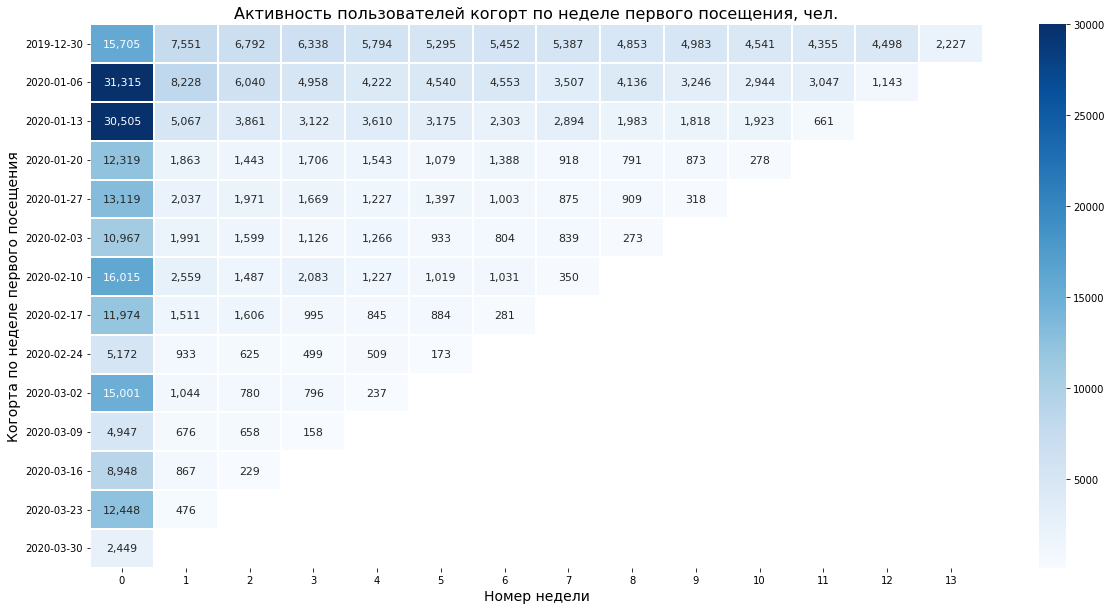

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
fig = sns.heatmap(fs_cohort_df, annot=True, fmt=',.0f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=150, vmax=30000)
fig.set_title('Активность пользователей когорт по неделе первого посещения, чел.', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первого посещения', size= 14)
plt.show()

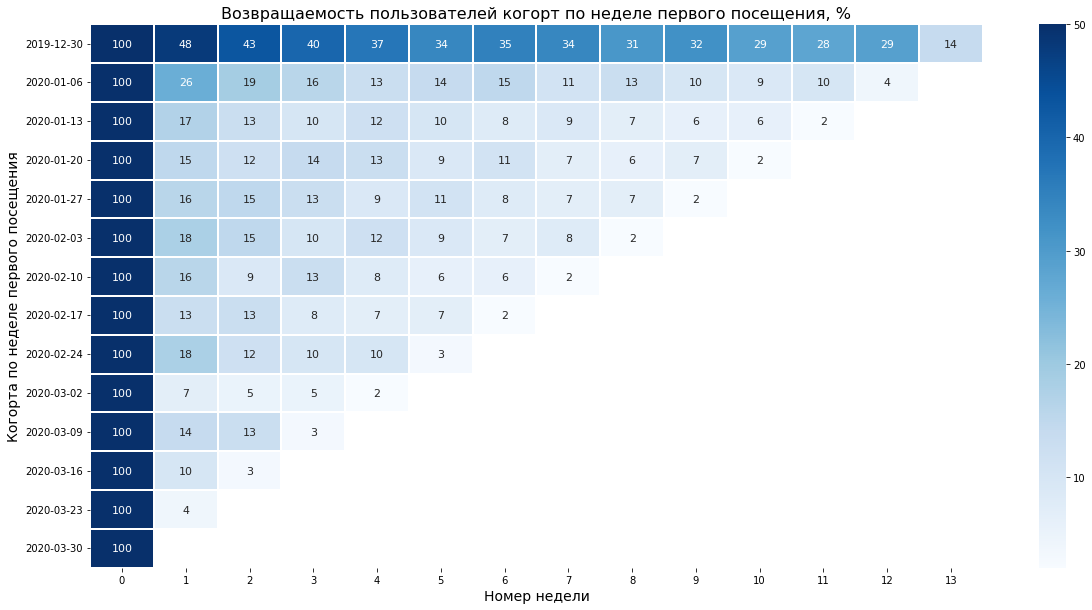

In [27]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fs_cohort_df2, annot=True, fmt='.0f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=2, vmax=50)
fig.set_title('Возвращаемость пользователей когорт по неделе первого посещения, %', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первого посещения', size= 14)
plt.show()

***Самой многочисленной когортой по неделе первого посещения является когорта от 06.01.2020г. Самой активной когортой является когорта 30.12.2019г. (абсолютный лидер по возвращаемости пользователей среди когорт, возвращаемость по остальным когортам падает заметно быстрее начиная уже с первой недели жизни).*** 

Теперь сформируем когорты пользователей по неделе первой покупки. Для этого создадим сводную таблицу *fp_cohort_df,* в которой подсчитаем количество уникальных пользователей в каждой когорте понедельно в динамике за весь срок существования когорты. На основании полученной таблицы создадим также таблицу *fp_cohort_df2,* в которой посчитаем коэффициент повторных покупок (Repeat Purchase Rate) пользователей сформированных когорт. Визуализируем полученные результаты с помощью тепловой карты. По оси абсцисс расположим номера недель жизни когорт, по оси ординат - когорты по неделе первой покупки.

In [28]:
fp_cohort_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', columns='fp_cohort_week', values='device_id', aggfunc='nunique').reset_index()
fp_cohort_df['first_purchase_cohort'] = fp_cohort_df['first_purchase_cohort'].astype(str)
fp_cohort_df.set_index('first_purchase_cohort', inplace=True)
fp_cohort_df2 = fp_cohort_df.apply(lambda x: round(x * 100 / fp_cohort_df[0]))

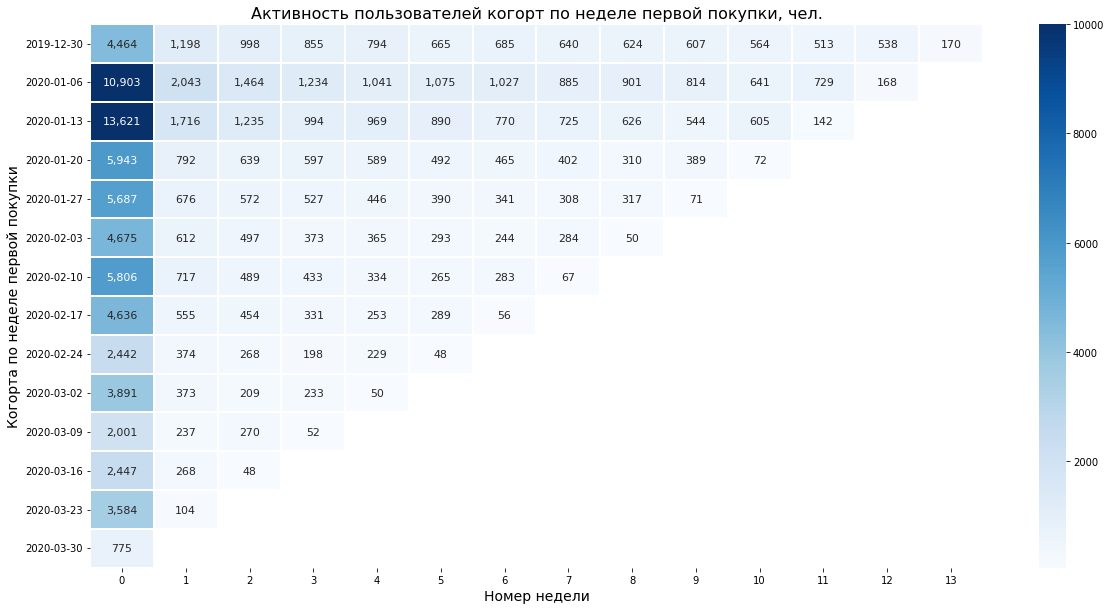

In [29]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fp_cohort_df, annot=True, fmt=',.0f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=50, vmax=10000)
fig.set_title('Активность пользователей когорт по неделе первой покупки, чел.', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

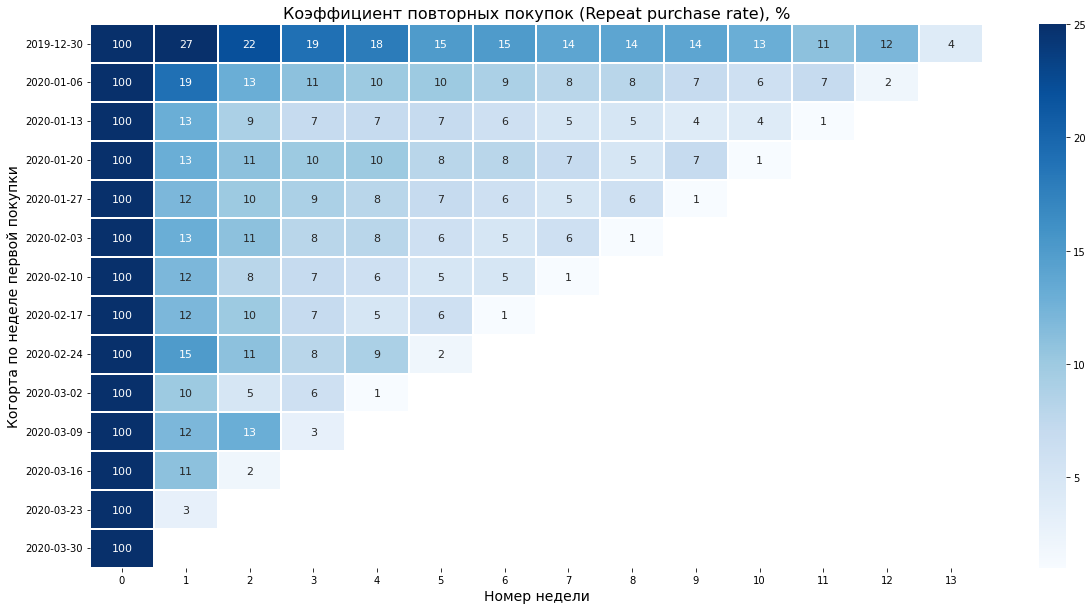

In [30]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fp_cohort_df2, annot=True, fmt='.0f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=1, vmax=25)
fig.set_title('Коэффициент повторных покупок (Repeat purchase rate), %', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

***Самой активной когортой по неделе первой покупки является когорта от 30.12.2019г. (абсолютный лидер по коэффициенту повторных покупок, у остальных когорт коэффициент падает сильнее, начиная с первой недели жизни). Самой многочисленной является когорта от 13.01.2020г.*** Динамика численности когорт по неделе первой покупки приблизительно повторяет динамику численности когорт по неделе привлечения, однако заметно снижение доли привлекаемых пользователей, в итоге переходящих к заказу товаров.

Посмотрим на размер медианного чека у когорт по неделе первой покупки. Для этого создадим сводную таблицу *fp_cohort_median_df,* в которой подсчитаем сумму медианного чека в каждой когорте понедельно в динамике за весь срок существования когорты. Для визуализации полученных результатов снова используем тепловую карту. По оси абсцисс расположим номера недель жизни когорт, по оси ординат - когорты по неделе первой покупки.

In [31]:
fp_cohort_median_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', columns='fp_cohort_week', values='purchase_sum', aggfunc='median').reset_index()
print('Ответ на вопрос Задания 1.2.4: Медианный чек на неделе первой покупки выше у когорты {}.'.format(fp_cohort_median_df.iloc[fp_cohort_median_df[0].argmax(), 0].strftime('%d-%m-%Y')))
fp_cohort_median_df['first_purchase_cohort'] = fp_cohort_median_df['first_purchase_cohort'].astype(str)
fp_cohort_median_df.set_index('first_purchase_cohort', inplace=True)

Ответ на вопрос Задания 1.2.4: Медианный чек на неделе первой покупки выше у когорты 09-03-2020.


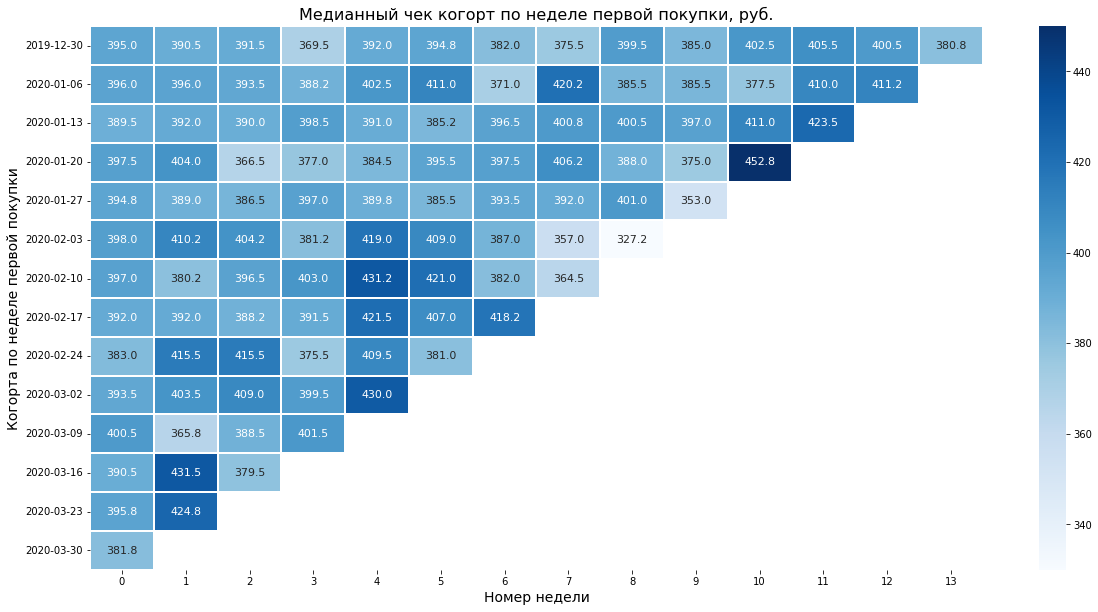

In [32]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fp_cohort_median_df, annot=True, fmt='.1f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=330, vmax=450)
fig.set_title('Медианный чек когорт по неделе первой покупки, руб.', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

По размеру медианного чека уверенного лидера среди когорт нет, можно выделить когорту 13.01.2020г., размер медианного чека которой имеет стабильную тенденцию роста, в остальных когортах динамика показателя разнонаправленная.

Определим диапазоны значений медианного чека по когортам, для чего сформируем таблицу median_range_df, в которой соберём минимальные и максимальные показатели.

In [33]:
median_range_df = pd.DataFrame({'min_median': fp_cohort_median_df.min(axis=1, numeric_only=True), 'max_median': fp_cohort_median_df.max(axis=1, numeric_only=True)}).reset_index()
median_range_df = round(median_range_df, 2)
display(median_range_df)

,first_purchase_cohort,min_median,max_median
0,2019-12-30,369.50,405.50
1,2020-01-06,371.00,420.25
2,2020-01-13,385.25,423.50
3,2020-01-20,366.50,452.75
4,2020-01-27,353.00,401.00
5,2020-02-03,327.25,419.00
6,2020-02-10,364.50,431.25
7,2020-02-17,388.25,421.50
8,2020-02-24,375.50,415.50
9,2020-03-02,393.50,430.00


Посмотрим на размер среднего чека у когорт по неделе первой покупки. Для этого создадим сводную таблицу *fp_cohort_mean_df,* в которой подсчитаем сумму среднего чека в каждой когорте понедельно в динамике за весь срок существования когорты. Визуализируем полученные результаты с помощью тепловой карты.

In [34]:
fp_cohort_mean_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', columns='fp_cohort_week', values='purchase_sum', aggfunc='mean').reset_index()
fp_cohort_mean_df['first_purchase_cohort'] = fp_cohort_mean_df['first_purchase_cohort'].astype(str)
fp_cohort_mean_df.set_index('first_purchase_cohort', inplace=True)

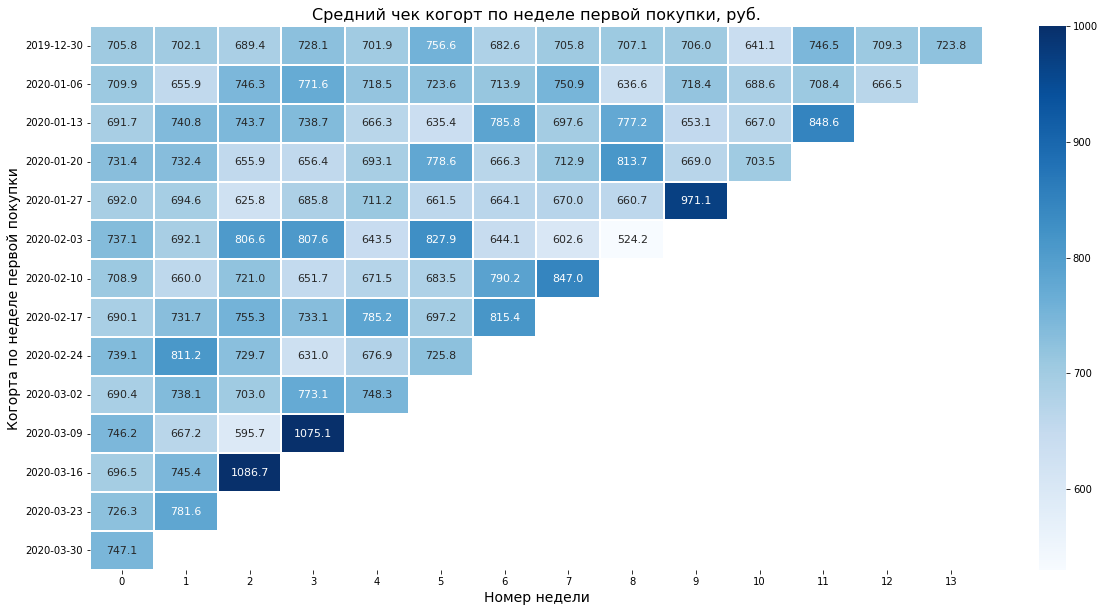

In [35]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fp_cohort_mean_df, annot=True, fmt='.1f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=530, vmax=1000)
fig.set_title('Средний чек когорт по неделе первой покупки, руб.', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

По недельному среднему чеку выделить какую-либо когорту со стабильно растущим показателем не представляется возможным, динамика разнонаправленная. Наименьший разброс значений наблюдается в когорте 30.12.2019г.

Определим диапазоны значений среднего чека по когортам, для чего сформируем таблицу mean_range_df, в которой соберём минимальные и максимальные показатели.

In [36]:
mean_range_df = pd.DataFrame({'min_mean': fp_cohort_mean_df.min(axis=1, numeric_only=True), 'max_mean': fp_cohort_mean_df.max(axis=1, numeric_only=True)}).reset_index()
mean_range_df = round(mean_range_df, 2)
display(mean_range_df)

,first_purchase_cohort,min_mean,max_mean
0,2019-12-30,641.12,756.62
1,2020-01-06,636.61,771.55
2,2020-01-13,635.41,848.61
3,2020-01-20,655.91,813.67
4,2020-01-27,625.78,971.07
5,2020-02-03,524.19,827.88
6,2020-02-10,651.68,847.01
7,2020-02-17,690.07,815.42
8,2020-02-24,630.97,811.24
9,2020-03-02,690.39,773.09


Чтобы понять, в какой когорте сосредоточены платящие клиенты, приносящие максимальный доход, рассчитаем метрику ARPPU (средний доход на одного платящего пользователя). Для начала создадим сводную таблицу *fp_cohort_revenue_df,* в которой подсчитаем понедельно суммы продаж в каждой когорте. Разделим полученные данные по продажам на еженедельное количество уникальных платящих клиентов по когортам из таблицы *fp_cohort_df* и результат запишем в переменную *fp_cohort_arppu_df*. Визуализируем полученные результаты с помощью тепловой карты. По оси абсцисс расположим номера недель жизни когорт, по оси ординат - когорты по неделе первой покупки.

In [37]:
fp_cohort_revenue_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', columns='fp_cohort_week', values='purchase_sum', aggfunc='sum').reset_index()
fp_cohort_revenue_df['first_purchase_cohort'] = fp_cohort_revenue_df['first_purchase_cohort'].astype(str)
fp_cohort_revenue_df.set_index('first_purchase_cohort', inplace=True)
fp_cohort_arppu_df = fp_cohort_revenue_df / fp_cohort_df

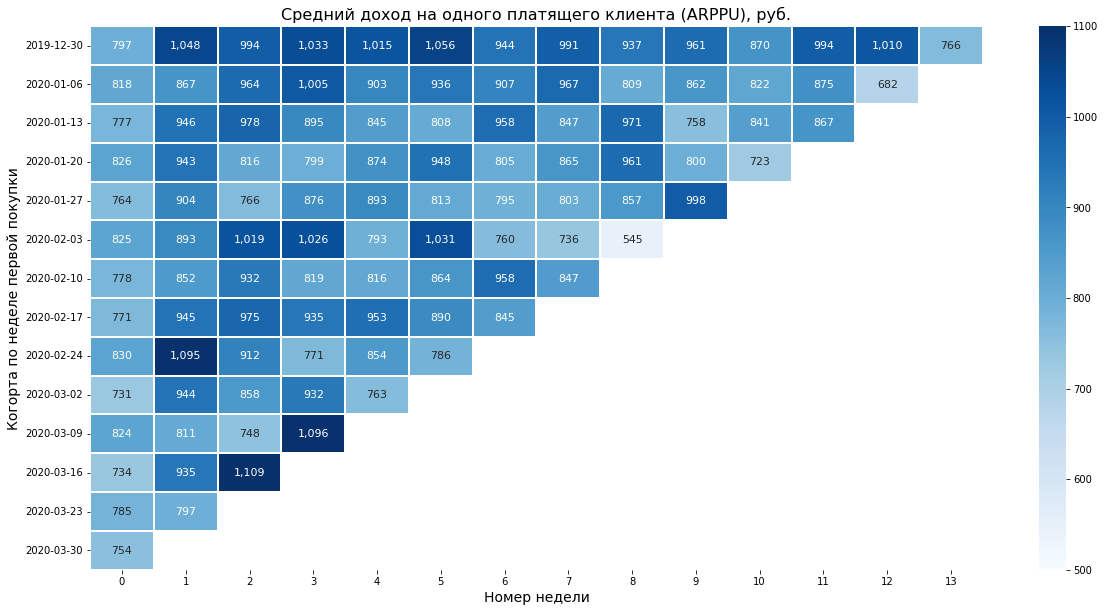

In [38]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(fp_cohort_arppu_df, annot=True, fmt=',.0f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=500, vmax=1100)
fig.set_title('Средний доход на одного платящего клиента (ARPPU), руб.', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

***Когорта 30.12.2019г. практически на протяжении всего срока жизни имеет наибольший ARPPU среди всех когорт по неделе первой покупки.***

Рассчитаем метрику Purchase Frequency (частота покупок). Для этого создадим сводную таблицу *fp_cohort_purchases_df,* в которой подсчитаем понедельно количество продаж в каждой когорте. Разделим полученные данные на еженедельное количество уникальных платящих клиентов по когортам из таблицы *fp_cohort_df* и результат запишем в переменную *purchases_frequency_df*. Визуализируем полученные результаты с помощью тепловой карты. По оси абсцисс расположим номера недель жизни когорт, по оси ординат - когорты по неделе первой покупки.

In [39]:
fp_cohort_purchases_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', columns='fp_cohort_week', values='event', aggfunc=len).reset_index()
fp_cohort_purchases_df['first_purchase_cohort'] = fp_cohort_purchases_df['first_purchase_cohort'].astype(str)
fp_cohort_purchases_df.set_index('first_purchase_cohort', inplace=True)
purchase_frequency_df = fp_cohort_purchases_df / fp_cohort_df

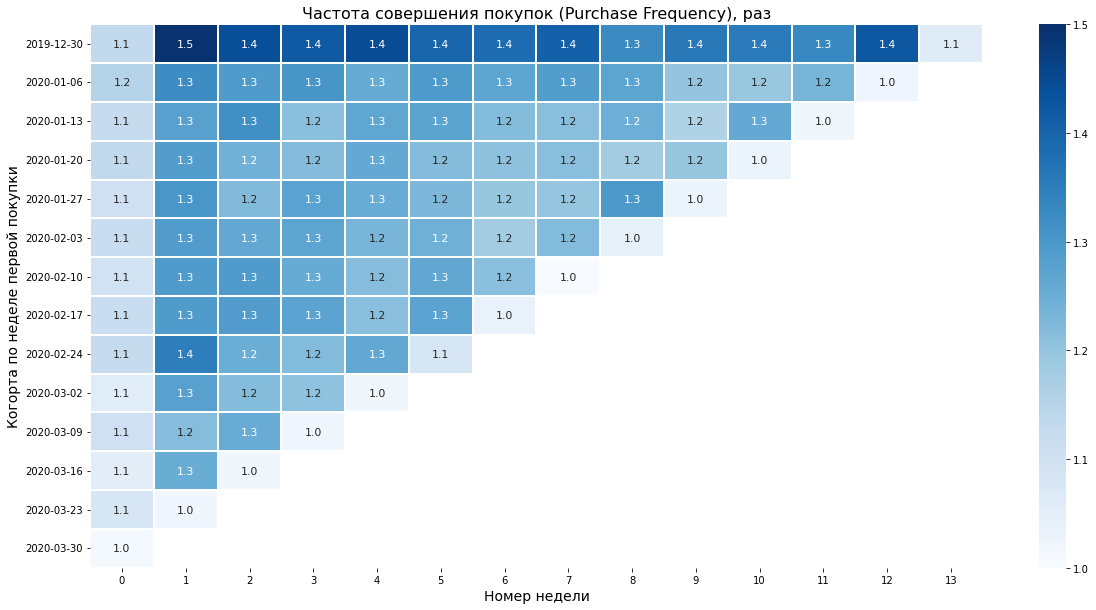

In [40]:
plt.figure(figsize=(20, 10))
fig = sns.heatmap(purchase_frequency_df, annot=True, fmt='.1f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=1, vmax=1.5)
fig.set_title('Частота совершения покупок (Purchase Frequency), раз', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Когорта по неделе первой покупки', size= 14)
plt.show()

***Частота совершения покупок клиентами из когорты 30.12.2019г. выше, чем у остальных когорт. В среднем активные клиенты этой когорты совершают 1,4 покупки в неделю.***

Посмотрим на то, какая когорта принесла нам больше всего денег за период своего существования. Для этого создадим сводную таблицу *fp_cohort_LTV_df,* в которой подсчитаем итоговую сумму продаж в каждой когорте по неделе первой покупки.

In [41]:
fp_cohort_LTV_df = pd.pivot_table(cohorts_df[cohorts_df['event'] == 'purchase'], index='first_purchase_cohort', values='purchase_sum', aggfunc='sum').reset_index()
fp_cohort_LTV_df.rename({'purchase_sum': 'LTV'}, axis=1, inplace=True)
display(fp_cohort_LTV_df)
print()
print('Ответ на вопрос Задания 1.2.3: Больше всего денег принесла когорта {}.'.format(fp_cohort_LTV_df.iloc[fp_cohort_LTV_df['LTV'].argmax(), 0].strftime('%d-%m-%Y')))

,first_purchase_cohort,LTV
0,2019-12-30,12320177.5
1,2020-01-06,19787838.0
2,2020-01-13,18852452.0
3,2020-01-20,9018049.5
4,2020-01-27,7432634.0
5,2020-02-03,6305237.0
6,2020-02-10,6766314.0
7,2020-02-17,5398837.5
8,2020-02-24,3067633.5
9,2020-03-02,3629773.0



Ответ на вопрос Задания 1.2.3: Больше всего денег принесла когорта 06-01-2020.


***Когорта от 06.01.2020г. заработала больше всего денег за период своего существования. Максимальная численность когорты от 13.01.2020г. позволила ей стать второй по результативности, несмотря на самые низкие из тройки лидеров показатели ARPPU и Repeat purchase rate. Когорта 30.12.2019г., имея самые высокие показатели ARPPU и Repeat purchase rate, заняла лишь 3-е место в списке самых результативных когорт по сумме заработанных денег, что произошло по причине её малочисленности (4464 чел. в сравнении с 10903 чел. и 13621 чел. в когортах-лидерах).***

Проведём небольшое исследование состава когорты, оказавшейся наилучшей по показателям возвращаемости, ARPPU и частоты покупок, чтобы попытаться составить "портрет" наших самых лояльных и прибыльных клиентов.

Для этого создадим копию таблицы *cohort_df,* оставив только события "покупка", совершённые пользователями когорты 30.12.2019г., и запишем её в переменную *first_fp_cohort_df.* Создадим из неё сводную таблицу, в которой в качестве строк используем такие данные о клиенте, как город, пол и ОС устройства, в качестве столбцов номера недель жизни когорты, а в значениях посчитаем количество уникальных пользователей. Визуализируем полученные результаты с помощью тепловой карты. По оси абсцисс расположим номера недель жизни когорты, по оси ординат - подгруппы в разрезе города, пола пользователей и ОС устройства.

In [42]:
first_fp_cohort_df = cohorts_df[(cohorts_df['event'] == 'purchase') & (cohorts_df['first_purchase_cohort'] == '2019-12-30')].copy()
first_fp_cohort_df = pd.pivot_table(first_fp_cohort_df, values='device_id', index=['city', 'gender', 'os_name'], columns='fp_cohort_week', aggfunc='nunique')
first_fp_cohort_df = first_fp_cohort_df.apply(lambda x: round(x * 100 / x.sum(), 1))

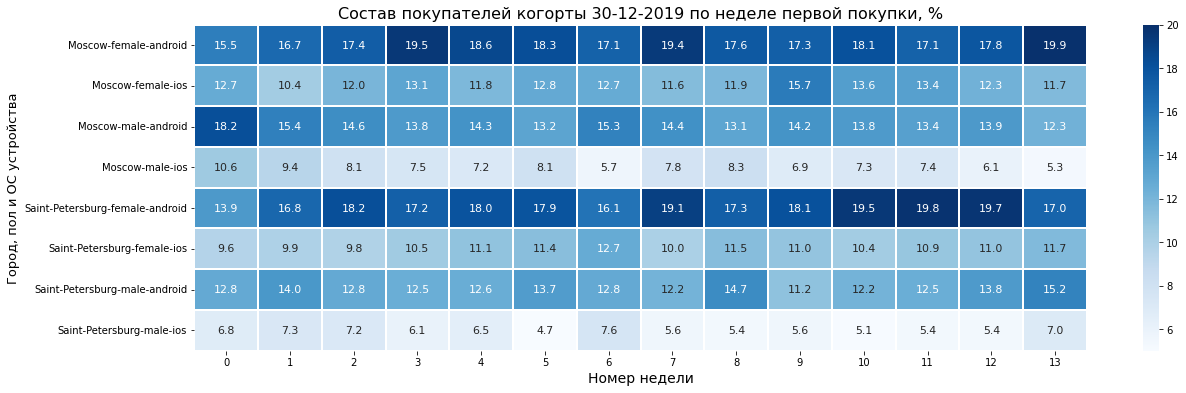

In [43]:
plt.figure(figsize=(20, 6))
fig = sns.heatmap(first_fp_cohort_df, annot=True, fmt='.1f', annot_kws={'size': 11}, cmap= 'Blues', linewidths= 1, vmin=5, vmax=20)
fig.set_title('Состав покупателей когорты 30-12-2019 по неделе первой покупки, %', size= 16)
fig.set_xlabel('Номер недели', size= 14)
fig.set_ylabel('Город, пол и ОС устройства', size= 13)
plt.show()

В момент формирования когорты она состояла на 57% из жителей Москвы и на 43% из жителей Санкт-Петербурга. В период жизни когорты можно заметить постепенное снижение доли пользователей из Москвы - к концу рассматриваемого периода она снизилась до 49%. Снижение доли произошло за счёт сильного оттока пользователей мужского пола (с 29% при формировании когорты их доля упала до 18% в конце периода) вне зависимости от ОС устройства, при этом доля пользователей женского пола выросла (с 28% при формировании когорты до 32% в конце периода). Рост доли пользователей из Санкт-Петербурга сформирован увеличением долей пользователей женского пола (с 24% при формировании когорты их доля выросла до 29% в конце периода) и мужского пола (с 20% увеличилась до 22% в конце периода). 

По гендерному составу в момент формирования когорта состояла из двух практически равных частей: пользователи женского пола составили 52%, а мужского - 48%. Однако к концу рассматриваемого периода структура изменилась: пользователи женского пола составили 60%, а мужского - 40%.

**Выводы.**

Сложившаяся ситуация с резким снижением возвращаемости пользователей в сервис уже со второй недели использования и дальнейшим падением к нему интереса наглядно иллюстрирует нам то, что можно привлекать качественный трафик и наращивать аудиторию, но без достаточных усилий по удержанию клиентов мы будем бесконечно тратить деньги. Согласно статьи The Value of Keeping the Right Customers (Ценность удержания нужных клиентов), опубликованной на сайте Harvard Business Review, привлечь нового клиента стоит в 5–25 раз дороже, чем удержать существующего **(1).** В статье "Prescription for cutting costs" (Рецепт для сокращения расходов) аналитик компании Bain & Company, входящей в «большую тройку» лидеров управленческого консалтинга, указывает на то, что по результатам исследований увеличение показателя retention на 5% влечет за собой рост дохода более чем на 25% **(2).** Именно удерживая пользователей и превращая их в лояльных клиентов, мы можем рассчитывать на рост. 

По результатам проведённого когортного анализа пользователей наиболее перспективной для проведения дальнейшего исследования является когорта покупателей от 30.12.2019г. Она имеет самые высокие показатели Repeat purchase rate, ARPPU и Purchase Frequency. Проведя исследование этой когорты можно использовать полученные выводы в работе с пользователями более многочисленных когорт, сделать работу над ошибками и применить их при разработке новой маркетинговой стратегии.

Из проведённого нами исследования состава указанной когорты можно сделать вывод, что наиболее лояльной аудиторией оказались пользователи женского пола, а меньше всего наш сервис устроил пользователей мужского пола (необходим более детальный анализ обеих подгрупп). 
Также прослеживается некоторое влияние ОС устройств на динамику состава когорты: пользователи с устройствами на ОС ios при прочих равных условиях либо показывают большее снижение доли, либо меньший её рост. Необходимо более детальное исследование, возможно в приложении под ОС ios есть какие-то баги/сложности.

**Предложения.**

Для улучшения удержания пользователей в нашем сервисе необходимо предпринять несколько шагов:
1. Продумать эффективную программу лояльности, которая из простых клиентов сделает постоянных, ведь как показывают результаты глобального исследования The Loyalty Report 2020, проведённого Visa и Bond Brand Loyalty, участники персонализированной программы лояльности остаются с брендом в 5.4 раза дольше и тратят в 6.4 раза больше **(3).** Своими рекомендациями такие клиенты бесплатно приведут к нам новых клиентов и благотворно повлияют на имидж компании. 

2. Периодически устраивать конкурсы, розыгрыши и акции, проводить опросы, увеличивая, таким образом, целевую аудиторию. Опросы также помогут выявить проблемы с интерфейсом или работоспособностью приложения, со скоростью доставки заказов или с недостаточным ассортиментом товаров. 

3. Использовать товарные рекомендации с учетом истории покупок, персональные подборки товаров, скидки на товары, которые ранее просматривал пользователь или добавил в список желаний.

4. Давать клиентам возможность оставлять обратную связь о компании, анализировать её, отвечать на комментарии, разбирать конфликтные ситуации и решать их. Это вызовет доверие со стороны текущих и даже потенциальных клиентов.



---

***Источники:***

(1) https://hbr.org/2014/10/the-value-of-keeping-the-right-customers

(2) https://media.bain.com/Images/BB_Prescription_cutting_costs.pdf

(3) https://retail-loyalty.org/news/trendy-programm-loyalnosti-v-2020-godu-issledovanie-visa-i-bond-brand-loyalty-/